# HW 2

Deep Learning, Spring 2022

Use neural networks to the fit one year's worth of solar wind measurements.

This notebook can be run on Google Colab via https://colab.research.google.com/drive/1hTJfsN9oHJctkeXBR9EIIAwdFZZGSr7H?usp=sharing

In [6]:
# Import dependencies
from time import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch modules
import torch

# Check GPU availability - may not be needed since relatively small models
torch.cuda.is_available()

False

# 1. Data preprocessing

The CSV files should be in the same directory as this notebook or linked somehow - update `url` and `url2` accordingly.

References:
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

## 1.1 Read CSV and define variable categories

The CSV file is stored in a public GitHub repository for convenience. Alternatively, reference a local file or upload the file into Colab's runtime.

Ignore the mixed types warning as the last few columns are for physical constants that only span some rows.

In [7]:
url = 'https://raw.githubusercontent.com/vtd9/multilayer-perceptron/' + \
  'temp_space/Sample_Data_Set.csv'
url2 ='https://raw.githubusercontent.com/vtd9/multilayer-perceptron/' + \
  'temp_space/v2_Sample_Data_Set.csv'
df = pd.concat([pd.read_csv(url), pd.read_csv(url2, low_memory=False)])

In [8]:
# Independent variables
indep_vars = ['Bx', 'By', 'Bz', 'Bmag_avg', 'Ni_avg', 'Vx', 'Vy', 'Vz', 'VSW', 
              'Vth_mag_Ion', 'Vth_para_Ion', 'Vth_perp_Ion', 'Ne', 'Ue', 
              'Te', 'Ti', 'Ti_para', 'Ti_perp']

# Derived variables: from independent variables using formulas
deriv_vars = ['VA', 'Beta', 'Beta_para', 'Beta_perp', 
              'Omega_i', 'omega_pi', 'omega_pe', 'rho_i', 'rho_s', 'rho_c', 
              'd_i', 'd_e', 'sigma_i', 'Lperp', 'lambda_d']

# Dependent variable: target
dep_var = ['k_brk']

# Check that the number of variables in each category are as expected
print('Independent: {}, derived: {}, dependent: {}'.format(
    len(indep_vars), len(deriv_vars), len(dep_var)))

# Convert Pandas dataframes to PyTorch tensors by column names
indep = torch.tensor(df[indep_vars].values)
deriv = torch.tensor(df[deriv_vars].values)
dep = torch.tensor(df[dep_var].values)

# Summary stats
df[dep_var].describe()

Independent: 18, derived: 15, dependent: 1


,k_brk
count,1.073660e+05
mean,5.348346e-06
std,3.486439e-06
min,9.965770e-07
25%,2.865257e-06
50%,4.234454e-06
75%,6.790123e-06
max,3.195988e-05


## 1.2 Prepare for feeding into network

In [9]:
# Normalize inputs & combine with dependent variable to create datasets
indep_set = torch.utils.data.TensorDataset(
    torch.nn.functional.normalize(indep, dim=0), dep)
deriv_set = torch.utils.data.TensorDataset(
    torch.nn.functional.normalize(deriv, dim=0), dep)

# Check dimensions
print(indep_set[:][0].shape, deriv_set[:][0].shape)

# Decide on training, validation, and testing splits
train_size = int(0.7 * len(df))
valid_size = int(0.15 * len(df)) + 1
test_size = len(df) - (train_size + valid_size)
splits = [train_size, valid_size, test_size]

print('Training, validation, & testing split:', splits)

# Split the data for both indep-dep pairs & derived-dep pairs
train_indep, valid_indep, test_indep = torch.utils.data.random_split(
    indep_set, splits)
train_deriv, valid_deriv, test_deriv = torch.utils.data.random_split(
    deriv_set, splits)

# Define dataloaders
BATCH_SIZE = 128
NUM_WORK = 2
train_loader_indep = torch.utils.data.DataLoader(
    dataset=train_indep, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORK)
valid_loader_indep = torch.utils.data.DataLoader(
    dataset=valid_indep, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORK)
test_loader_indep = torch.utils.data.DataLoader(
    dataset=test_indep, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
train_loader_deriv= torch.utils.data.DataLoader(
    dataset=train_deriv, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
valid_loader_deriv = torch.utils.data.DataLoader(
    dataset=valid_deriv, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
test_loader_deriv = torch.utils.data.DataLoader(
    dataset=test_deriv, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)

torch.Size([107366, 18]) torch.Size([107366, 15])
Training, validation, & testing split: [75156, 16105, 16105]


## 1.3 Visualize the input data

In [72]:
def plot_many(X, y, names, cols=6, title='', subfont=10, size=(10, 8),
              color='b', sample=10000, marker=','):
  '''
  Plot multiple variables against a single one.
  '''
  num_plots = len(names)
  num_rows = int(num_plots / cols) + 1
  plt.subplots(figsize=size)
  plt.suptitle(title)

  # Random sample
  indices = torch.randperm(X.shape[0])[:sample]

  # For each variable in X
  for i in range(num_plots):
      plt.subplot(num_rows, cols, i + 1)
      plt.plot(X[:, i][indices], y[indices], marker, alpha=0.5, color=color)
      plt.title(names[i], y=1.1, fontsize=subfont)
      plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')
      plt.xticks(fontsize=0.9*subfont)
  plt.tight_layout(rect=[0, 0.01, 1, 1])
  plt.subplots_adjust(top=0.9)

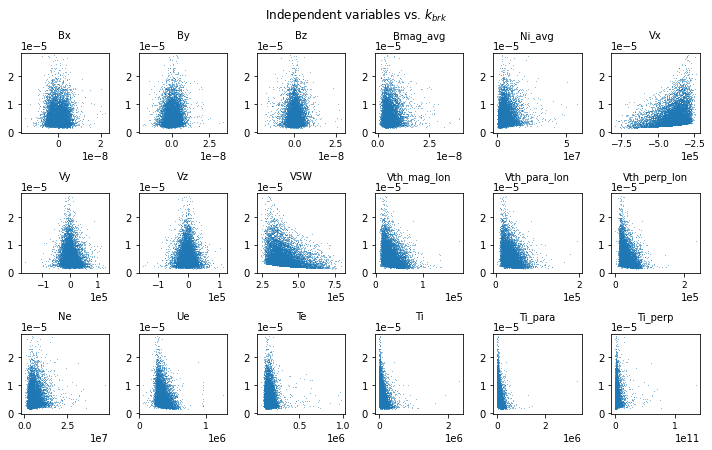

In [73]:
plot_many(indep, dep[:, 0], indep_vars, 
          title='Independent variables vs. $k_{brk}$', color='tab:blue')

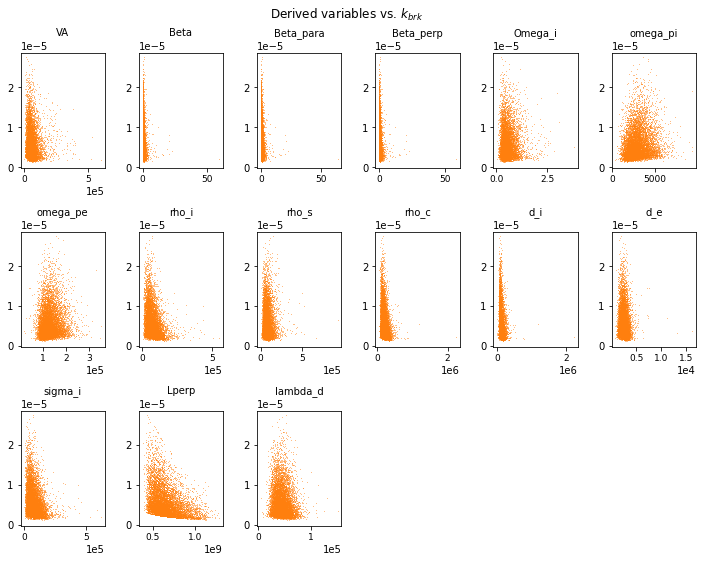

In [74]:
plot_many(deriv, dep[:, 0], deriv_vars, 
          title='Derived variables vs. $k_{brk}$', color='tab:orange')

# 2. Define classes and functions

References:
* https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

## 2.1 `Net` class

Define a general template to easily create models.

The order of activation, batch normalization, and dropout, and whether dropout is necessary when the model has batch normalization has been debated:
* https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout. 
* https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization/tutorial

Here, apply activation, batch normalization, then dropout.

In [13]:
class Net(torch.nn.Module): 
  def __init__(self, n_in, hiddens, n_out, batch_norm=True, p_dropout=0.5,
               use_prelu=False):
    super(Net, self).__init__()
    self.n_in = n_in
    self.n_out = n_out
    layers = []
    
    # Define hidden layer(s)
    hiddens_list = [n_in, ] + list(hiddens)
    for i, hidden in enumerate(hiddens_list[:-1]):
      curr_hidden = []
      curr_hidden.append(torch.nn.Linear(hidden, hiddens_list[i+1]))

      # Add activation (ReLU)
      if not use_prelu:
        curr_hidden.append(torch.nn.ReLU())
      else:
        curr_hidden.append(torch.nn.PReLU())

      # If set, add batch normalization
      if batch_norm:
          curr_hidden.append(torch.nn.BatchNorm1d(hiddens_list[i+1]))

      # If set, add dropout
      if p_dropout is not None:
          curr_hidden.append(torch.nn.Dropout(p_dropout))  

      layers += curr_hidden 

    # Define output layer
    layers.append(torch.nn.Linear(hiddens[-1], n_out))

    # Define entire stack
    self.stack = torch.nn.Sequential(*layers)
      
  def forward(self, x):
      logits = self.stack(x)
      return logits

# Initialize parameters
def init_parameters(m):
  if isinstance(m, torch.nn.Linear):
      # weights: Kaiming initialization
      torch.nn.init.kaiming_normal_(m.weight)

      # biases: set to 0, as discussed in class
      m.bias.data.fill_(0.0) # Set bias to 0

In [14]:
def mult_models(n_in, hidden_dims, n_out, lr, momentum=0.9,
                decay=1e-5, opt_sgd=True, one_model=True, use_prelu=False):
  '''
  Create multiple models using one or more configurations for the hidden 
  layers. Return as a dictionary with keys based on the number of neurons in
  the hidden layers as well the model-specific add-ons or lack thereof.
  '''
  models_dict = {}
  for dim in hidden_dims:  
    # Batch norm & dropout of 50%
    model = Net(n_in, dim, n_out, use_prelu=use_prelu)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), 
                                  lr=lr, weight_decay=decay)}

    if not one_model: # Create more models with less components
      # Batch norm, but no dropout
      model = Net(n_in, dim, n_out, p_dropout=None, use_prelu=use_prelu)
      model.apply(init_parameters)
      if opt_sgd:
        models_dict[str(dim) + ' no drop'] = {
            'model': model,
            'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=momentum, weight_decay=decay)}
      else:
            models_dict[str(dim) + ' no drop'] = {
            'model': model,
            'opt': torch.optim.Adam(model.parameters(), lr=lr)}
      
      # No norm, no dropout
      model = Net(n_in, dim, n_out, batch_norm=False, p_dropout=None, 
                  use_prelu=use_prelu)
      model.apply(init_parameters)
      if opt_sgd:
        models_dict[str(dim) + ' no norm'] = {
            'model': model,
            'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=momentum, weight_decay=decay)}
      else:
            models_dict[str(dim) + ' no norm'] = {
            'model': model,
            'opt': torch.optim.Adam(model.parameters(), lr=lr)}

  return models_dict

## 2.2 Training, testing, and plotting functions

Train & test functions for one loop through the datasets (aka one epoch) as well as loop over multiple epochs.

Option to configure a GPU with PyTorch.

* https://pytorch.org/docs/stable/notes/cuda.html
* https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [15]:
def train_loop(loader, model, loss_fun, optimizer, device='cpu'):
  '''
  Train a model for one epoch - i.e., one pass through the training data set.
  '''
  train_loss = 0.0
  model = model.double()
  model = model.to(device)
  model.train() # set the module in training mode

  # For each batch
  for X, y in loader:
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad() # clear previous gradients
    yhat = model(X) # prediction
    loss = loss_fun(yhat, y) # compute loss
    train_loss += loss.item() # assume reduction over batch

    loss.backward() # compute gradients
    optimizer.step() # apply gradients
  return train_loss/len(loader) # average over number of batches
    
def test_loop(loader, model, loss_fun, device='cpu', get_jacobian=False,
              get_xy=False):
  '''
  Test a model through one pass through a validation/test data set.
  '''
  test_loss = 0.0
  model = model.double()
  model = model.to(device)
  model.eval() # set the module in evaluation mode

  if get_jacobian:
    jacobians = torch.tensor([])
  else:
    xy = torch.tensor([])

  # No backprop during validation/testing
  with torch.no_grad():
    for i, (X, y) in enumerate(loader):
      X = X.to(device)
      y = y.to(device)
      yhat = model(X)
      test_loss += loss_fun(yhat, y).item()

      if get_jacobian:
        # Get Jacobian using torch, reducing over the batch together
        # Add in corresponding predictions for later usage
        jacobians = torch.concat(
            [jacobians, torch.concat([
                torch.autograd.functional.jacobian(model, X).sum(dim=0)[0],
                yhat, y], dim=1)])
      else:
        # Get X with its predicted yhat
        xy = torch.concat(
            [xy, torch.concat([X, yhat, y], dim=1)])

  if get_jacobian:
    return test_loss/len(loader), jacobians
  elif get_xy:
    return test_loss/len(loader), xy
  else:
    return test_loss/len(loader)

def train_epochs(train_loader, valid_loader, model, loss_fun, optimizer, 
    epochs, verbose=False, use_gpu=False):
    '''
    Train and validate a model over multiple epochs.
    '''
    train_losses = torch.empty(epochs)
    valid_losses = torch.empty(epochs)

    if use_gpu:
      device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    else:
      device = 'cpu'

    # For each epoch
    for epoch in range(epochs):
        train_losses[epoch] = train_loop(train_loader, model, 
            loss_fun, optimizer=optimizer, device=device)
        valid_losses[epoch] = test_loop(valid_loader, model, 
                                       loss_fun, device=device)
        if verbose:
            print('epoch: {}\ttraining loss: {:.3e}'
            '\tvalidation loss: {:.3e}'.format(
                epoch, train_losses[epoch], valid_losses[epoch]))
    
    return train_losses, valid_losses

### 2.2.1 Multiple models

Functions to handle multiple models.

In [16]:
def train_mult_models(models, train_loader, valid_loader, loss_fun,
                      epochs=25, verbose=False, use_gpu=False,
                      train_index=0, valid_index=1):
  '''
  Train (and validate) multiple models in sequence. Assume `models` is a
  dictionary produced by the above function `mult_models`.
  '''
  fun_start = time()
  for key, value in models.items():
    start = time()
    model = value['model']
    opt = value['opt']
    models[key]['result'] = train_epochs(
        train_loader, valid_loader, model, 
        loss_fun=loss_fun, optimizer=opt, epochs=epochs, verbose=verbose,
        use_gpu=use_gpu)
    print('{0: <20}'.format(key), '{:.1f}s'.format(time() - start),
          'train loss: {:.3e}'.format(models[key]['result'][train_index][-1]),
          'valid loss: {:.3e}'.format(models[key]['result'][valid_index][-1]))
  print('Total time: {:.1f}s'.format(time() - fun_start))


def plot_mult_models(models, xlabel='Epoch', ylabel='Mean squared error',
                     yscale='log', title='', train_index=0, valid_index=1,
                     result_key='result', train_append=' training', 
                     valid_append=' validation', train_style='-', 
                     valid_style='--', figsize=(8, 5)):
  '''
  Plot the results of multiple models on the same graph, each with its own 
  training and validation performances.
  '''
  colors=itertools.cycle(('tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                          'tab:purple', 'tab:pink','b', 'y', 'c', 'm', 'k',
                          'tab:gray', 'tab:olive'))
  plt.figure(figsize=figsize)
  for key, value in models.items():
    color = next(colors)
    epochs = value[result_key][0].shape[0]
    # Plot training performance
    plt.plot(np.arange(epochs), 
        value[result_key][train_index], train_style, 
        color=color, label=key+train_append)
    
    # Plot validation performance
    plt.plot(np.arange(epochs), 
        value[result_key][valid_index], valid_style, 
        color=color, label=key+valid_append)
  plt.title(title)
  plt.yscale(yscale)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.1))

# 3. Independent &rarr; dependent variables

Create a model to relate the independent variables to the dependent variable.

In [17]:
# Standard mean squared error loss function
mse = torch.nn.MSELoss(reduction='mean') # default reduction

# Hyperparameters
LEARN_RATE = 0.05
NUM_EPOCHS = 10

## 3.1 Three hidden layers

From prior runs, the performance of the models appear to plateau after ~3-4 epochs with a learning rate of ~0.05 to 0.1.

In [18]:
# Create container to store models, optimizers, & results in
m3 = mult_models(len(indep_vars), [(32, 16, 8), (8, 4, 2)], 
                 n_out=1, lr=LEARN_RATE, one_model=False)
# Train
train_mult_models(m3, train_loader_indep, valid_loader_indep, mse, NUM_EPOCHS)

(32, 16, 8) drop 50% 32.8s train loss: 1.245e-11 valid loss: 1.276e-11
(32, 16, 8) no drop  28.2s train loss: 3.708e-11 valid loss: 2.947e-11
(32, 16, 8) no norm  24.0s train loss: 5.096e-08 valid loss: 3.986e-09
(8, 4, 2) drop 50%   29.3s train loss: 1.239e-11 valid loss: 1.223e-11
(8, 4, 2) no drop    26.9s train loss: 1.204e-11 valid loss: 1.203e-11
(8, 4, 2) no norm    23.5s train loss: 1.162e-08 valid loss: 3.350e-09
Total time: 164.7s


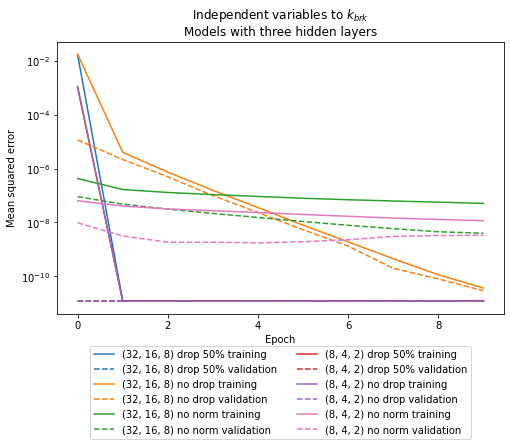

In [19]:
# Plot on log scale
plot_mult_models(m3, title='Independent variables to $k_{brk}$' 
                 + '\nModels with three hidden layers')

(1.1e-11, 1.4e-11)

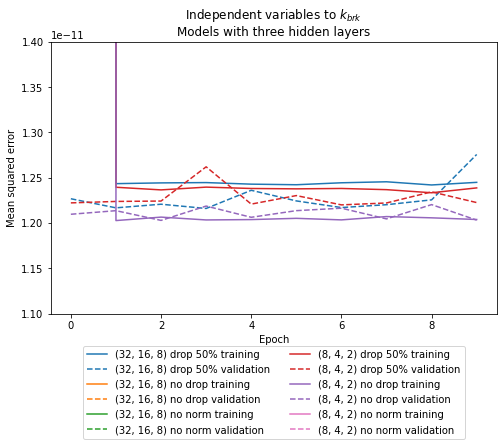

In [20]:
# Zoom in and plot on linear scale
plot_mult_models(m3, yscale='linear', title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers')
plt.ylim(1.1e-11, 1.4e-11)

#### 3.1.1 ADAM

Experiment with another optimization algorithm, ADAM, instead of stochastic gradient descent (SGD).

In [21]:
m3a = mult_models(len(indep_vars), [(32, 16, 8), (8, 4, 2)], 1, 
                  lr=LEARN_RATE, opt_sgd=False, one_model=True)
train_mult_models(m3a, train_loader_indep, valid_loader_indep, mse, 
                  epochs=NUM_EPOCHS)

(32, 16, 8) drop 50% 31.1s train loss: 1.876e-06 valid loss: 6.513e-08
(8, 4, 2) drop 50%   30.3s train loss: 2.260e-06 valid loss: 8.965e-06
Total time: 61.4s


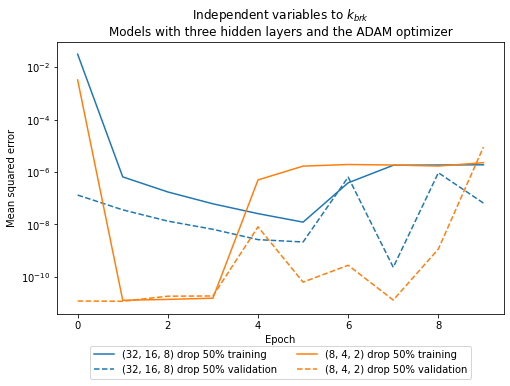

In [22]:
plot_mult_models(m3a, 
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers and the ADAM optimizer')

## 3.2 Four hidden layers

In [23]:
m4 = mult_models(len(indep_vars), [(24, 16, 8, 4), (12, 8, 4, 2)], 1, 
                 LEARN_RATE)
train_mult_models(m4, train_loader_indep, valid_loader_indep, mse, 
                  epochs=NUM_EPOCHS)

(24, 16, 8, 4) drop 50% 30.7s train loss: 1.265e-11 valid loss: 1.226e-11
(12, 8, 4, 2) drop 50% 33.0s train loss: 1.235e-11 valid loss: 1.241e-11
Total time: 63.6s


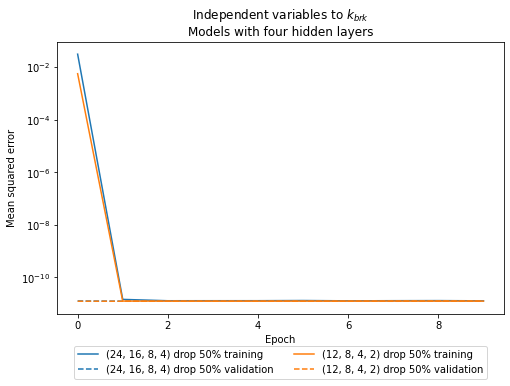

In [24]:
plot_mult_models(m4,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')

(1.1e-11, 1.5e-11)

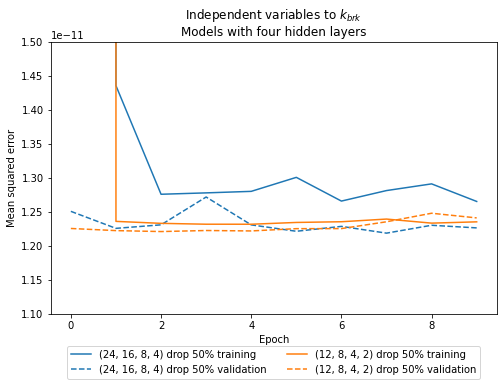

In [25]:
plot_mult_models(m4, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

## 3.3 Five hidden layers

In [26]:
# Create container to store models, optimizers, & results in
m5 = mult_models(len(indep_vars), [(32, 20, 16, 8, 4), (16, 12, 8, 4, 2)],
                 1, LEARN_RATE)
# Train
train_mult_models(m5, train_loader_indep, valid_loader_indep, mse, 
                  epochs=NUM_EPOCHS)

(32, 20, 16, 8, 4) drop 50% 34.1s train loss: 1.238e-11 valid loss: 1.224e-11
(16, 12, 8, 4, 2) drop 50% 39.7s train loss: 1.286e-11 valid loss: 1.229e-11
Total time: 73.8s


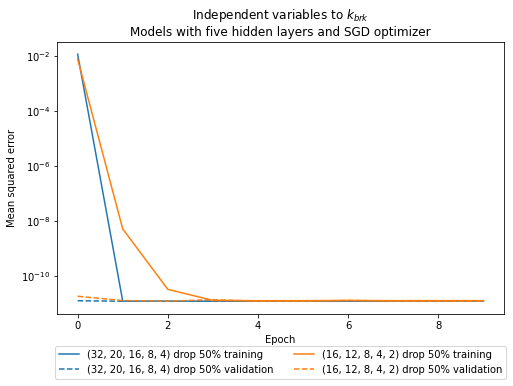

In [27]:
plot_mult_models(m5,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')

(1.1e-11, 1.4e-11)

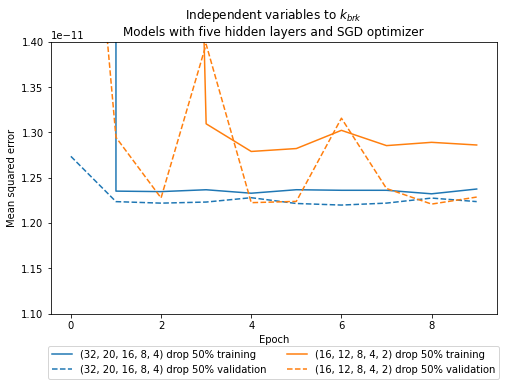

In [28]:
plot_mult_models(m5, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')
plt.ylim(1.1e-11, 1.4e-11)

## 3.4 Test dataset

Report chosen model's performance with test set & get gradients.

In [29]:
model = m3['(8, 4, 2) no drop']['model']
test_loss, j_indep = test_loop(test_loader_indep, model, mse, get_jacobian=True)
print('Test set MSE: {:.3e}'.format(test_loss))

Test set MSE: 1.145e-11


In [30]:
# Test set predictions
j_indep[:, -1].mean(), j_indep[:, -1].std()

(tensor(5.3333e-06, dtype=torch.float64),
 tensor(3.4166e-06, dtype=torch.float64))

In [31]:
# Get predictions and labels with their inputs for a total of 18+2=20 columns
_, xy_indep = test_loop(test_loader_indep, model, mse, get_xy=True)
xy_indep.shape

torch.Size([16105, 20])

# 4. Derived &rarr; dependent variables

## 4.1 Three hidden layers

In [32]:
# Create container to store models, optimizers, & results in
m3v = mult_models(len(deriv_vars), [(32, 16, 8), (8, 4, 2)], 
                  n_out=1, lr=LEARN_RATE)
# Train
train_mult_models(m3v, train_loader_deriv, valid_loader_deriv, mse, NUM_EPOCHS)

(32, 16, 8) drop 50% 32.4s train loss: 1.199e-11 valid loss: 1.203e-11
(8, 4, 2) drop 50%   29.5s train loss: 1.207e-11 valid loss: 1.265e-11
Total time: 62.0s


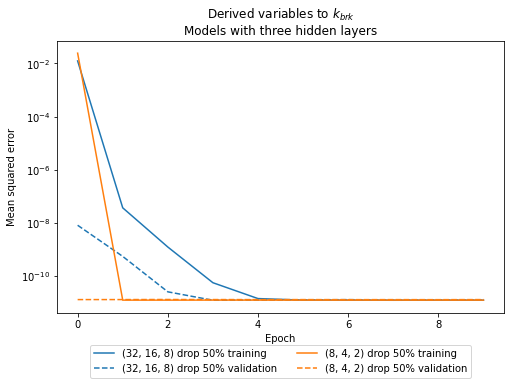

In [33]:
plot_mult_models(m3v,
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with three hidden layers')

(1.1e-11, 1.5e-11)

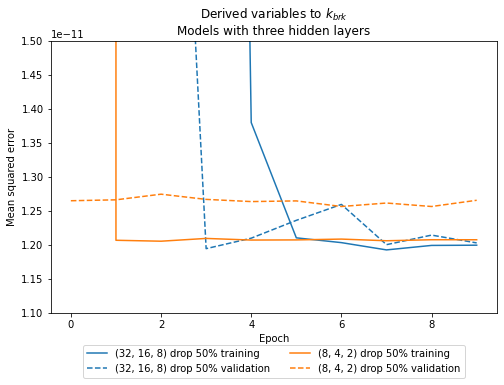

In [34]:
plot_mult_models(m3v, yscale='linear',
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with three hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

## 4.2 Four hidden layers

In [35]:
m4v = mult_models(len(deriv_vars), [(24, 16, 8, 4), (12, 8, 4, 2)], 1, 
                 LEARN_RATE)
train_mult_models(m4v, train_loader_deriv, valid_loader_deriv, mse, 
                  epochs=NUM_EPOCHS)

(24, 16, 8, 4) drop 50% 32.0s train loss: 1.221e-11 valid loss: 1.232e-11
(12, 8, 4, 2) drop 50% 33.1s train loss: 1.248e-11 valid loss: 1.271e-11
Total time: 65.1s


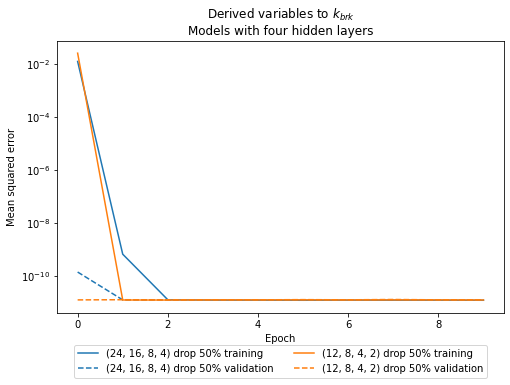

In [36]:
plot_mult_models(m4v,
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with four hidden layers')

(1.1e-11, 1.5e-11)

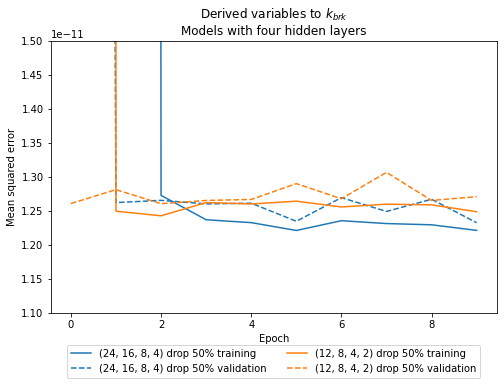

In [37]:
plot_mult_models(m4v, yscale='linear',
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with four hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

## 4.3 Five hidden layers

In [63]:
# Create container to store models, optimizers, & results in
# Try models without dropout & batch normalization again
m5v = mult_models(len(deriv_vars), [(32, 20, 16, 8, 4), (16, 12, 8, 4, 2)],
                  1, LEARN_RATE, one_model=False)
# Train
train_mult_models(m5v, train_loader_deriv, valid_loader_deriv, mse, 
                  epochs=NUM_EPOCHS)

(32, 20, 16, 8, 4) drop 50% 36.5s train loss: 1.224e-11 valid loss: 1.265e-11
(32, 20, 16, 8, 4) no drop 30.9s train loss: 1.188e-11 valid loss: 1.240e-11
(32, 20, 16, 8, 4) no norm 25.7s train loss: 3.916e-09 valid loss: 5.102e-09
(16, 12, 8, 4, 2) drop 50% 32.5s train loss: 1.239e-11 valid loss: 1.265e-11
(16, 12, 8, 4, 2) no drop 30.3s train loss: 1.192e-11 valid loss: 1.258e-11
(16, 12, 8, 4, 2) no norm 24.7s train loss: 8.753e-10 valid loss: 2.343e-09
Total time: 180.7s


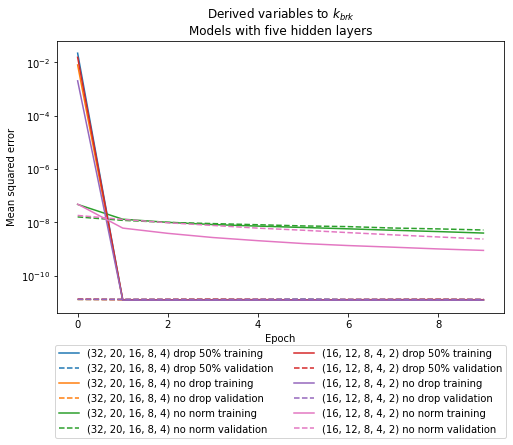

In [64]:
plot_mult_models(m5v,
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with five hidden layers')

(1.1e-11, 1.5e-11)

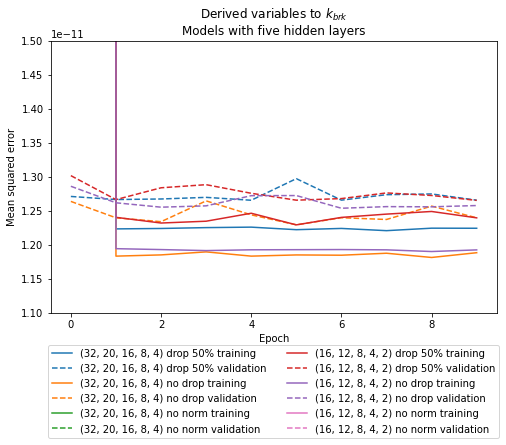

In [65]:
plot_mult_models(m5v, yscale='linear',
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with five hidden layers')
plt.ylim(1.1e-11, 1.5e-11)

## 4.4 Test loss

In [41]:
model = m3v['(8, 4, 2) drop 50%']['model']
test_loss, j_deriv = test_loop(test_loader_deriv, model, mse, get_jacobian=True)
print('Test set MSE: {:.3e}'.format(test_loss))

# Test set predictions
j_deriv[:, -1].mean(), j_deriv[:, -1].std(), j_deriv.shape

Test set MSE: 1.225e-11


(tensor(5.3369e-06, dtype=torch.float64),
 tensor(3.5014e-06, dtype=torch.float64),
 torch.Size([16105, 17]))

In [42]:
_, xy_deriv = test_loop(test_loader_deriv, model, mse, get_xy=True)
xy_deriv.shape

torch.Size([16105, 17])

# 5. Derivatives

## 5.1 Analytical differentiation

As described in the attached report, the derivatives of the independent and derived variables related to `k_brk` were found by hand. These are defined below for later comparison with the gradients from the neural network.

In [43]:
def dk_brk_dlambda_r(lambda_r, A=1):
  '''Derivative of k_brk wrt lambda_r'''
  return -A * lambda_r**-2

def dlamda_r_dLperp(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt Lperp'''
  return (1./9.) * C0 * Lperp**(-8./9.)*(d_e*rho_s)**(4./9.)

def dlambda_r_dd_e(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt d_e '''
  return C0 * Lperp**(1./9.) * (4./9.) * (d_e*rho_s)**(-5./9.) * rho_s

def dlambda_r_rho_s(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt rho_s'''
  return C0 * Lperp**(1./9.) * (4./9.) * (d_e*rho_s)**(-5./9.) * d_e

def dLperp_dvsw():
  '''Derivative of Lperp wrt VSW'''
  return 1./(2 * torch.pi * 10**-4)

def dde_domega_pe(omega_pe, c=2.9979E8):
  '''Derivative of '''
  return -c * omega_pe**-2

def drho_s_drho_i(Te, Ti, Z=1.0):
  '''Derivative of '''
  return (Z*Te / (2*Ti))**0.5

def drho_s_dTi(rho_i, Te, Ti, Z=1.0):
  '''Derivative of '''
  return -0.5 * rho_i * (Z*Te / (2.0*Ti**3))**0.5

def drho_s_dTe(rho_i, Te, Ti, Z=1.0):
  '''Derivative of '''
  return 0.5 * rho_i * (Z / (2.0*Ti*Te))**0.5

def domega_pe_dNe(Ne, e=1.6022E-19, eps0=8.8542E-12, mp=9.1094E-31):
  '''Derivative of omega_pe wrt Ne'''
  return 0.5 * (e**2 / (eps0*mp*Ne))**0.5

def drho_i_Vth_perp_Ion(Omega_i):
  '''Derivative of rho_i wrt Vth_perp_Ion'''
  return 1/Omega_i

def drho_i_dOmega_i(Vth_perp_Ion, Omega_i):
  '''Derivative of rho_i wrt Omega_i'''
  return -Vth_perp_Ion/Omega_i**2

def dOmega_i_dB(e=1.6022E-19, mp=9.1094E-31):
  '''Derivative of Omega_i wrt B'''
  return e/mp

def dB_i_dBx(Bx, By, Bz):
  '''Derivative of B wrt Bx'''
  return Bx * (Bx**2 + By**2 + Bz**2)**(-0.5)

def dB_i_dBy(Bx, By, Bz):
  '''Derivative of B wrt By'''
  return By * (Bx**2 + By**2 + Bz**2)**(-0.5)

def dB_i_dBz(Bx, By, Bz):
  '''Derivative of B wrt Bz'''
  return Bz * (Bx**2 + By**2 + Bz**2)**(-0.5)

In [44]:
def derive_from_tensors(indep_vars, deriv_vars, indep_tensor, deriv_tensor):
  '''
  Derive k_brk wrt different variables using the formulas & the chain rule.
  '''
  grads = {}

  # step 1: From k_brk to lambda_r (lambda_d in spreadsheet)
  grads['lambda_d'] = dk_brk_dlambda_r(
      deriv_tensor[:, deriv_vars.index('lambda_d')])

  # step 2: lambda_r to Lperp, d_e, & rho_s
  grads['Lperp'] = grads['lambda_d'] * dlamda_r_dLperp(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])
  grads['d_e'] = grads['lambda_d'] * dlambda_r_dd_e(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])
  grads['rho_s'] = grads['lambda_d'] * dlambda_r_rho_s(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])

  # step 3: d_e to omega_pe; rho_s to rho_i, Ti, & Te
  grads['VSW'] = grads['Lperp'] * dLperp_dvsw()
  grads['omega_pe'] = grads['d_e'] * dde_domega_pe(
      deriv_tensor[:, deriv_vars.index('omega_pe')])
  grads['rho_i'] = grads['rho_s'] * drho_s_drho_i(
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])
  grads['Ti'] = grads['rho_s'] * drho_s_dTi(
      deriv_tensor[:, deriv_vars.index('rho_i')],       
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])
  grads['Te'] = grads['rho_s'] * drho_s_dTe(
      deriv_tensor[:, deriv_vars.index('rho_i')],       
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])

  # step 4: omega_pe to Ne; rho_i to Vth_perp_Ion & Omega_i
  grads['Ne'] = grads['omega_pe'] * domega_pe_dNe(
      indep_tensor[:, indep_vars.index('Ne')])
  grads['Vth_perp_Ion'] = grads['rho_i'] * drho_i_Vth_perp_Ion(
      deriv_tensor[:, deriv_vars.index('Omega_i')])
  grads['Omega_i'] = grads['rho_i'] * drho_i_dOmega_i(
      indep_tensor[:, indep_vars.index('Vth_perp_Ion')], 
      deriv_tensor[:, deriv_vars.index('Omega_i')])

  # step 5: B and its components
  grads['Bmag_avg'] = grads['Omega_i'] * dOmega_i_dB()
  grads['Bx'] = grads['Bmag_avg'] * dB_i_dBx(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])
  grads['By'] = grads['Bmag_avg'] * dB_i_dBy(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])
  grads['Bz'] = grads['Bmag_avg'] * dB_i_dBz(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])   
  return grads

In [45]:
# Execute
grads = derive_from_tensors(indep_vars, deriv_vars,
                            indep_set[:][0], deriv_set[:][0])
grads_unnorm = derive_from_tensors(indep_vars, deriv_vars,
                            indep, deriv)

print('Derivative of k_brk wrt to...\nNormalized inputs')
for key, value in grads.items():
  print('{0: <15}'.format(key), 
        '{:.3e}\t{:.3e}'.format(value.max().item(), value.min().item()))
print('*'*60, '\nUnnormalized inputs')
for key, value in grads_unnorm.items():
  print('{0: <15}'.format(key), 
        '{:.3e}\t{:.3e}'.format(value.max().item(), value.min().item()))

Derivative of k_brk wrt to...
Normalized inputs
lambda_d        -1.389e+03	-4.555e+07
Lperp           -1.251e+03	-2.761e+05
d_e             -1.044e+03	-1.357e+06
rho_s           -2.164e+02	-6.249e+08
VSW             -1.990e+06	-4.395e+08
omega_pe        4.714e+19	4.000e+17
rho_i           -2.126e+03	-2.865e+08
Ti              9.013e+06	4.034e+02
Te              -1.197e+03	-3.972e+05
Ne              1.480e+23	1.043e+20
Vth_perp_Ion    -1.078e+06	-4.638e+10
Omega_i         2.792e+08	1.257e+06
Bmag_avg        4.911e+19	2.211e+17
Bx              4.462e+19	-2.369e+19
By              1.719e+19	-1.647e+19
Bz              1.597e+19	-1.670e+19
************************************************************ 
Unnormalized inputs
lambda_d        -6.056e-12	-1.986e-07
Lperp           -4.088e-16	-9.027e-14
d_e             -8.609e-11	-1.120e-07
rho_s           -5.360e-13	-1.548e-06
VSW             -6.507e-13	-1.437e-10
omega_pe        2.150e-09	1.824e-11
rho_i           -5.854e-12	-7.890e-07
Ti         

In [67]:
def one_subplot(rows, cols, i, key, subtitle=10):
      plt.subplot(rows, cols, i + 1)
      plt.title(key, y=1.15, fontsize=subtitle)
      plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')
      plt.xticks(fontsize=0.8*subtitle, rotation=45)
      plt.yticks(fontsize=0.8*subtitle)

def plot_grads(grads, dep, title='', cols=6, sample=5000, figsize=(7, 7), 
               names=None, color='k', marker='.'):
  '''
  Plot partial derivatives from generated dictionary or those from a
  neural network.
  '''
  plt.subplots(figsize=figsize)
  plt.suptitle(title)

  if type(grads) == dict:
    rows = int(len(grads) / cols) + 1
    # Take random sample
    indices = torch.randperm(list(grads.values())[0].shape[0])[:sample]
    for i, (key, value) in enumerate(grads.items()):
      one_subplot(rows, cols, i, key)
      plt.plot(value[indices], dep[indices], marker, color=color)

  else:
    rows = int(grads.shape[-1] / cols) + 1
    # Assume data has already been shuffled before being fed into NN
    assert len(names) == grads.shape[-1]
    for i, key in enumerate(names):
      one_subplot(rows, cols, i, key)
      value = grads[:, i]
      plt.plot(value[:sample], dep[:sample], marker, color=color)
  plt.tight_layout(rect=[0, 0.01, 1, 1])
  plt.subplots_adjust(top=0.88)

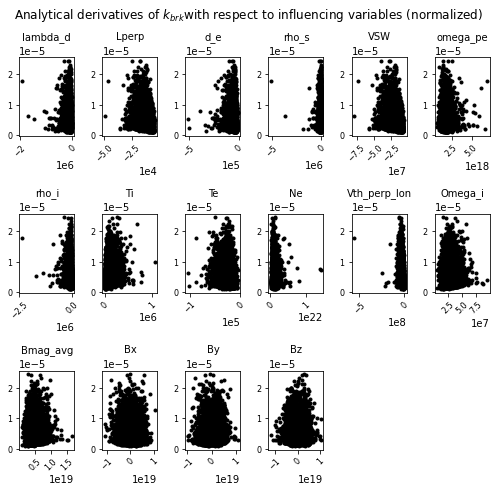

In [68]:
plot_grads(grads, dep, 
           title='Analytical derivatives of $k_{brk}$' +
           'with respect to influencing variables (normalized)')

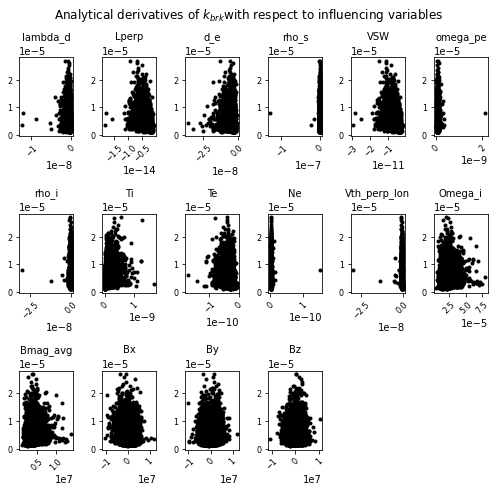

In [69]:
plot_grads(grads_unnorm, dep, 
           title='Analytical derivatives of $k_{brk}$' +
           'with respect to influencing variables')

## 5.2 Neural network gradients

From the chosen models, get the Jacobian tensor.

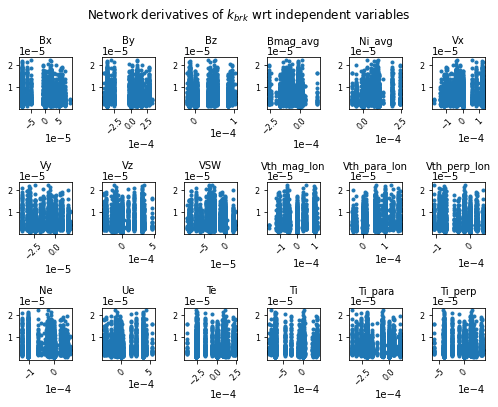

In [70]:
plot_grads(j_indep[:, 0:len(indep_vars)], j_indep[:, -1], names=indep_vars,
           title='Network derivatives of $k_{brk}$ wrt independent variables',
           color='tab:blue')

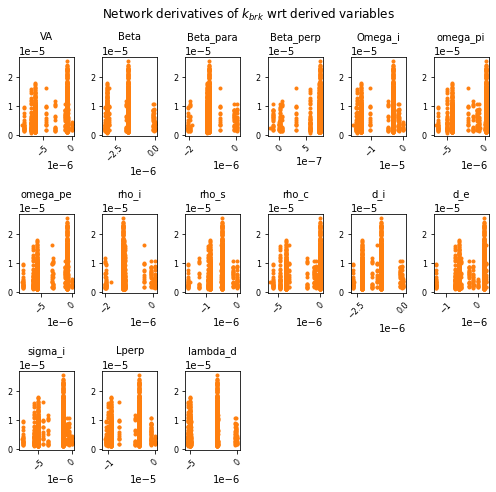

In [71]:
plot_grads(j_deriv[:, 0:len(deriv_vars)], j_deriv[:, -1], names=deriv_vars,
           title='Network derivatives of $k_{brk}$ wrt derived variables',
           color='tab:orange')

# 6. Correlation between $\lambda_{brk}$ and $\lambda_r$

From equation 16 in the data set description file, $\lambda_{brk}$ and $\lambda_r$ are thought to be proportional of each other.

In [51]:
# Pandas has a function to calculate the correlation coefficient for
# all pairwise combinations
dep_vars = dep_var + ['l_brk',]
df[indep_vars + dep_vars].corr()

,Bx,By,Bz,Bmag_avg,Ni_avg,Vx,Vy,Vz,VSW,Vth_mag_Ion,Vth_para_Ion,Vth_perp_Ion,Ne,Ue,Te,Ti,Ti_para,Ti_perp,k_brk,l_brk
Bx,1.000000,-0.375732,-0.017180,0.088805,-0.042644,-0.124252,0.032533,0.055232,0.124712,0.110922,0.075016,0.121895,-0.037879,0.088402,0.004909,0.063135,0.111948,-0.032241,-0.027664,0.038639
By,-0.375732,1.000000,-0.004323,0.059418,0.081736,0.092581,0.028161,-0.057179,-0.092669,-0.095955,-0.075635,-0.099425,0.074979,-0.077946,-0.044349,-0.066092,-0.099277,0.071980,0.036476,-0.045428
Bz,-0.017180,-0.004323,1.000000,-0.033758,0.014345,0.018691,-0.004574,0.060484,-0.018596,-0.017403,-0.013305,-0.019177,0.018803,0.006431,-0.000989,-0.009158,-0.014213,0.019538,-0.000972,-0.001393
Bmag_avg,0.088805,0.059418,-0.033758,1.000000,0.294085,-0.139042,0.045863,-0.015260,0.144241,0.243775,0.186195,0.259693,0.381116,0.203403,0.272532,0.195668,0.257549,0.348755,0.057491,-0.042705
Ni_avg,-0.042644,0.081736,0.014345,0.294085,1.000000,0.325285,-0.128368,-0.061475,-0.323595,-0.119862,-0.116637,-0.105456,0.928741,-0.089950,-0.184228,-0.079405,-0.082695,0.819329,0.155011,-0.164702
Vx,-0.124252,0.092581,0.018691,-0.139042,0.325285,1.000000,-0.284047,-0.023047,-0.999847,-0.675962,-0.588186,-0.681559,0.252719,-0.794587,-0.233546,-0.486209,-0.592044,0.132356,0.322473,-0.423782
Vy,0.032533,0.028161,-0.004574,0.045863,-0.128368,-0.284047,1.000000,0.018467,0.287146,0.387537,0.343784,0.381858,-0.103284,0.220149,0.062672,0.301549,0.349109,-0.097500,-0.092876,0.121739
Vz,0.055232,-0.057179,0.060484,-0.015260,-0.061475,-0.023047,0.018467,1.000000,0.020113,0.004722,0.003324,0.003711,-0.066551,0.014412,-0.039445,0.000048,0.007796,-0.057325,-0.007067,0.009931
VSW,0.124712,-0.092669,-0.018596,0.144241,-0.323595,-0.999847,0.287146,0.020113,1.000000,0.680146,0.591812,0.685917,-0.249878,0.794941,0.236999,0.490402,0.597190,-0.130036,-0.322580,0.423857
Vth_mag_Ion,0.110922,-0.095955,-0.017403,0.243775,-0.119862,-0.675962,0.387537,0.004722,0.680146,1.000000,0.929384,0.967638,0.014439,0.559081,0.342917,0.829782,0.886576,0.027975,-0.277529,0.330892


In [52]:
df[deriv_vars + dep_vars].corr()

,VA,Beta,Beta_para,Beta_perp,Omega_i,omega_pi,omega_pe,rho_i,rho_s,rho_c,d_i,d_e,sigma_i,Lperp,lambda_d,k_brk,l_brk
VA,1.000000,-0.305007,-0.336668,-0.282768,0.650342,-0.378396,-0.274149,-0.241344,-0.329392,0.177628,0.508041,0.357049,-0.300693,0.343854,-0.147256,-0.045051,0.069367
Beta,-0.305007,1.000000,0.983247,0.994827,-0.249271,0.217642,0.187187,0.584622,0.478802,0.212393,-0.168521,-0.177922,0.542271,0.060982,0.224848,-0.077058,0.083145
Beta_para,-0.336668,0.983247,1.000000,0.960653,-0.278555,0.210907,0.179172,0.580455,0.426648,0.227397,-0.204363,-0.177446,0.608393,0.046562,0.188385,-0.087020,0.086150
Beta_perp,-0.282768,0.994827,0.960653,1.000000,-0.229443,0.218144,0.188699,0.579372,0.500658,0.204111,-0.143498,-0.175107,0.499686,0.068685,0.241778,-0.070514,0.080565
Omega_i,0.650342,-0.249271,-0.278555,-0.229443,1.000000,0.282416,0.361483,-0.479801,-0.592526,-0.406511,-0.123765,-0.254181,-0.519169,0.144227,-0.639979,0.057479,-0.042693
omega_pi,-0.378396,0.217642,0.210907,0.218144,0.282416,1.000000,0.922313,-0.322333,-0.218339,-0.716494,-0.733954,-0.800173,-0.315627,-0.384970,-0.588085,0.177139,-0.194163
omega_pe,-0.274149,0.187187,0.179172,0.188699,0.361483,0.922313,1.000000,-0.287175,-0.252636,-0.646106,-0.652639,-0.892392,-0.295318,-0.293946,-0.632976,0.123807,-0.140955
rho_i,-0.241344,0.584622,0.580455,0.579372,-0.479801,-0.322333,-0.287175,1.000000,0.610615,0.751545,0.295732,0.244990,0.882092,0.477978,0.656580,-0.252394,0.300639
rho_s,-0.329392,0.478802,0.426648,0.500658,-0.592526,-0.218339,-0.252636,0.610615,1.000000,0.470352,0.304779,0.234991,0.412980,-0.019709,0.859312,-0.021227,0.040741
rho_c,0.177628,0.212393,0.227397,0.204111,-0.406511,-0.716494,-0.646106,0.751545,0.470352,1.000000,0.794170,0.640555,0.708056,0.505465,0.720249,-0.253082,0.292521


From neural networks, can correlate the inputs with predicted outputs.

In [53]:
# Independent variables
df_net_indep = pd.DataFrame(xy_indep.numpy()).copy() 
# any changes will not affect original tensor

# Invert k_brk columns to get lambda_brk ("l_brk")
df_net_indep.iloc[:, -2] = 1 / df_net_indep.iloc[:, -2]
df_net_indep.iloc[:, -1] = 1 / df_net_indep.iloc[:, -1]

df_net_indep.columns = indep_vars + ['l_brk_hat', 'l_brk_actual']
df_net_indep.corr()

,Bx,By,Bz,Bmag_avg,Ni_avg,Vx,Vy,Vz,VSW,Vth_mag_Ion,Vth_para_Ion,Vth_perp_Ion,Ne,Ue,Te,Ti,Ti_para,Ti_perp,l_brk_hat,l_brk_actual
Bx,1.000000,-0.381426,-0.012989,0.079502,-0.042000,-0.116800,0.025103,0.050838,0.117359,0.113142,0.072613,0.125129,-0.039380,0.084518,0.009332,0.055745,0.122820,-0.029323,0.040208,0.034793
By,-0.381426,1.000000,-0.008043,0.026545,0.057130,0.087187,0.043541,-0.058056,-0.087131,-0.078398,-0.052191,-0.086850,0.047958,-0.078755,-0.031806,-0.035195,-0.089988,0.030934,0.092749,-0.038294
Bz,-0.012989,-0.008043,1.000000,-0.023099,0.017292,0.017919,-0.008534,0.066764,-0.017778,-0.013894,-0.013736,-0.011989,0.020985,0.012229,0.006141,-0.004023,-0.001320,0.021549,-0.193645,-0.001210
Bmag_avg,0.079502,0.026545,-0.023099,1.000000,0.288859,-0.138544,0.046991,-0.016880,0.143643,0.246753,0.190609,0.261286,0.373947,0.196624,0.272958,0.195557,0.269684,0.351477,-0.087149,-0.031999
Ni_avg,-0.042000,0.057130,0.017292,0.288859,1.000000,0.331944,-0.130330,-0.060038,-0.330438,-0.130071,-0.124549,-0.116081,0.924479,-0.103926,-0.195518,-0.082839,-0.094153,0.823604,-0.333730,-0.157924
Vx,-0.116800,0.087187,0.017919,-0.138544,0.331944,1.000000,-0.278887,-0.021458,-0.999841,-0.668329,-0.577658,-0.673777,0.262288,-0.801880,-0.236074,-0.455628,-0.597089,0.134439,-0.334765,-0.426795
Vy,0.025103,0.043541,-0.008534,0.046991,-0.130330,-0.278887,1.000000,0.028196,0.282038,0.382154,0.334390,0.376498,-0.104925,0.215430,0.048835,0.273761,0.341444,-0.095484,0.326502,0.131192
Vz,0.050838,-0.058056,0.066764,-0.016880,-0.060038,-0.021458,0.028196,1.000000,0.018900,-0.002450,-0.005100,-0.002629,-0.069779,0.014047,-0.041376,-0.014866,0.001706,-0.060677,-0.094119,0.022182
VSW,0.117359,-0.087131,-0.017778,0.143643,-0.330438,-0.999841,0.282038,0.018900,1.000000,0.672592,0.581310,0.678394,-0.259577,0.802106,0.239742,0.459452,0.602780,-0.132231,0.333844,0.427075
Vth_mag_Ion,0.113142,-0.078398,-0.013894,0.246753,-0.130071,-0.668329,0.382154,-0.002450,0.672592,1.000000,0.924344,0.968120,0.006312,0.552724,0.340124,0.788032,0.892442,0.025462,0.494492,0.331162


In [54]:
# Derived variables
df_net_deriv = pd.DataFrame(xy_deriv.numpy()).copy() 
df_net_deriv.iloc[:, -2] = 1 / df_net_deriv.iloc[:, -2]
df_net_deriv.iloc[:, -1] = 1 / df_net_deriv.iloc[:, -1]

df_net_deriv.columns = deriv_vars + ['l_brk_hat', 'l_brk_actual']
df_net_deriv.corr()

,VA,Beta,Beta_para,Beta_perp,Omega_i,omega_pi,omega_pe,rho_i,rho_s,rho_c,d_i,d_e,sigma_i,Lperp,lambda_d,l_brk_hat,l_brk_actual
VA,1.000000,-0.281611,-0.311001,-0.262105,0.652405,-0.375896,-0.268536,-0.241680,-0.353148,0.174391,0.519499,0.353136,-0.299243,0.336885,-0.168234,0.537948,0.063510
Beta,-0.281611,1.000000,0.985938,0.995751,-0.232367,0.202428,0.170421,0.566704,0.470776,0.218554,-0.158651,-0.164821,0.525894,0.064128,0.224877,0.329407,0.082296
Beta_para,-0.311001,0.985938,1.000000,0.966983,-0.259318,0.196426,0.162731,0.562379,0.423062,0.231733,-0.192963,-0.163994,0.585131,0.049558,0.191766,0.310873,0.084060
Beta_perp,-0.262105,0.995751,0.966983,1.000000,-0.214667,0.203739,0.172872,0.562636,0.491350,0.209910,-0.136967,-0.163293,0.487956,0.071731,0.240278,0.336645,0.080491
Omega_i,0.652405,-0.232367,-0.259318,-0.214667,1.000000,0.279787,0.364785,-0.477535,-0.607881,-0.411670,-0.124748,-0.268641,-0.519336,0.141282,-0.650044,0.453589,-0.039890
omega_pi,-0.375896,0.202428,0.196426,0.203739,0.279787,1.000000,0.922991,-0.324076,-0.211900,-0.727869,-0.757747,-0.826417,-0.320478,-0.388381,-0.585525,-0.102712,-0.193717
omega_pe,-0.268536,0.170421,0.162731,0.172872,0.364785,0.922991,1.000000,-0.291515,-0.251320,-0.659175,-0.675273,-0.911711,-0.302435,-0.298576,-0.631937,0.001143,-0.139412
rho_i,-0.241680,0.566704,0.562379,0.562636,-0.477535,-0.324076,-0.291515,1.000000,0.618687,0.764485,0.302255,0.261440,0.885876,0.490573,0.666115,0.408141,0.302601
rho_s,-0.353148,0.470776,0.423062,0.491350,-0.607881,-0.211900,-0.251320,0.618687,1.000000,0.467883,0.287698,0.232489,0.427952,-0.019870,0.860486,0.087817,0.038582
rho_c,0.174391,0.218554,0.231733,0.209910,-0.411670,-0.727869,-0.659175,0.764485,0.467883,1.000000,0.785236,0.671126,0.725121,0.520850,0.727281,0.405160,0.294313


# Appendix

## A1. Simple experiments
Simple experiments on key functionality.

* https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
* https://pytorch.org/docs/stable/generated/torch.autograd.grad.html

Test Jacobian method with a simple neural network. Synthetic data functions are based on Dive into Deep Learning's examples:

* https://d2l.ai/chapter_linear-networks/linear-regression-concise.html
* https://d2l.ai/_modules/d2l/mxnet.html#synthetic_data

PyTorch documentation on `torch.autograd.functional.jacobian`: https://pytorch.org/docs/stable/generated/torch.autograd.functional.jacobian.html

In [55]:
i0 = torch.tensor([2., 4.], requires_grad=True)
i1 = torch.tensor([3., 5.], requires_grad=True)
z = 2.0*i0 + 3.0*i1 # dz_di0 = 2, dz_di1 = 3
y = z**2 # dy_dz = 2z
def y_fun(i0, i1):
  return (2.0*i0 + 3.0*i1)**2

print('z:', z.detach(), '\ty:', y.detach())
dy_dz = torch.autograd.grad(y, z, torch.ones(z.shape))[0]
print('dy/dz:', dy_dz)
print('dy/di0:', dy_dz * torch.autograd.grad(z, i0, torch.ones(i0.shape))[0])
print('dy/di1:', dy_dz * torch.autograd.grad(z, i1, torch.ones(i1.shape))[0])
print('dy/di0 & dy/di1 using jacobian:\n', 
      torch.autograd.functional.jacobian(y_fun, (i0, i1)))

z: tensor([13., 23.]) 	y: tensor([169., 529.])
dy/dz: tensor([26., 46.])
dy/di0: tensor([52., 92.])
dy/di1: tensor([ 78., 138.])
dy/di0 & dy/di1 using jacobian:
 (tensor([[52.,  0.],
        [ 0., 92.]]), tensor([[ 78.,   0.],
        [  0., 138.]]))


In [56]:
def load_array(data_arrays, batch_size, is_train=True): 
  '''Construct a PyTorch data iterator.'''
  dataset = torch.utils.data.TensorDataset(*data_arrays)
  return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

def synthetic(w, b, num_examples, stdev=0.1):
  '''Generate y = Xw + b + noise.'''
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y += torch.normal(0, stdev, y.shape)

  print('X.shape:', X.shape)
  return X, torch.reshape(y, (-1, 1))

def synthetic_only1(w, b, num_examples, stdev=0.1):
  '''y only depends on 1st input'''
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X[:, 0].reshape(-1, 1), w[0].unsqueeze(0)) + b
  y += torch.normal(0, stdev, y.shape)

  print('X.shape:', X.shape)
  return X, torch.reshape(y, (-1, 1))

def synthetic_quad(w, b, num_examples, stdev=0.1):
  '''Generate y = X0**2 + noise. Other input has no effect...'''
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = X[:, 0]**2
  y += torch.normal(0, stdev, y.shape)
  return X, torch.reshape(y, (-1, 1)) 

def train(data_iter, net, loss_fun, opt, gen_fun, num_epochs=3, 
    true_w = torch.tensor([2, -3.4])):
    '''Train a model'''
    # Store values at each epoch
    losses = np.empty(num_epochs)
    grad_losses = np.empty(num_epochs)

    # Train
    for epoch in range(num_epochs):
        net.train()
        loss_sum = 0.0
        grad_loss = 0.0
        for X, y in data_iter:
            # Forward
            yhat = net(X)
            loss = loss_fun(yhat, y)
            loss_sum += loss.item()

            # Backprop
            opt.zero_grad()
            loss.backward(retain_graph=True)
            grad_loss += get_jacobian(X, net, gen_fun, true_w=true_w)
            opt.step()

        losses[epoch] = loss_sum/len(data_iter)    
        grad_losses[epoch] = grad_loss/len(data_iter)
        print(f'epoch {epoch}, loss {losses[epoch]:f}, \
            grad compare {grad_losses[epoch]:f}')
    return X, y

def test_linear(w, b, gen_fun, net, opt, batch_size=5, epochs=3):
    features, labels = gen_fun(w, b, 1000) # generate data
    return train(load_array((features, labels), batch_size=batch_size), 
        net, torch.nn.MSELoss(), opt, gen_fun, num_epochs=epochs)

def plot_fit(gen_fun, w, b, model, num_examples=1000, idx=0):
    x, y = gen_fun(w, b, num_examples)
    x = x.detach()
    y = y.detach()
    yhat = model(x).detach()
    plt.plot(x[:, idx], y, '.', label='synthetic data')
    plt.plot(x[:, idx], yhat, 'x', label='predicted')
    plt.plot(x[:, idx], get_jacobian(x, model, gen_fun=gen_fun, return_col=True), 
             'o', label='grad')
    if gen_fun == synthetic_quad:
      plt.plot(x[:, idx], 2*x[:, idx], ',', label='analytical grad')
    elif gen_fun == synthetic_only1:
      plt.plot(x[:, idx], w[idx]*torch.ones(x[:, idx].shape),
               ',', label='analytical grad')
    plt.legend()
    plt.show()

def get_jacobian(X, net, gen_fun=synthetic_only1, 
                 true_w=torch.tensor([2, -3.4]), true_b=False, 
                 verbose=False, plot=False, return_col=False):
    # Set module to evaluation mode to turn off any dropout/batch norm layers
    net.eval() 

    with torch.no_grad():
        # Muck around with jacobian
        jacobian = torch.autograd.functional.jacobian(net, X)
        j_sum = jacobian.sum(dim=0)[0]

        # True gradients
        if gen_fun == synthetic_only1:
          # Derivative wrt 2nd input is 0
          # Sometimes can get pretty low mse differences, like 0.00113
            true_deriv = torch.concat(
                [true_w.repeat(j_sum.shape[0], 1)[:, 0].reshape(-1, 1),
                 torch.zeros((j_sum.shape[0], 1)).reshape(-1, 1)], 
                 axis=1)
        elif gen_fun == synthetic_quad:
          # Derivative wrt 2nd input is also 0
            true_deriv =  torch.concat(
                [2*X[:, 0].reshape(-1, 1), 
                 torch.zeros((j_sum.shape[0], 1)).reshape(-1, 1)], 
                 axis=1)
        else:
            true_deriv = true_w

        # Compute performance
        diff = true_deriv - j_sum
        mse_grad = torch.nn.MSELoss()(true_deriv, j_sum).item()
        if verbose: 
            print('Print one batch input & its Jacobian')
            print('Jacobian shape:', jacobian.shape)
            print('2X:', 2*X)
            print('Jacobian summed:', j_sum)
            print('mse diff:', mse_grad)
        if plot: plot_fit(gen_fun, true_w, true_b, net)
    if return_col:
        return j_sum[:, 0]
    return mse_grad

def run_net(net, opt, gen_fun=synthetic, plot=True, hand_calc=False, epochs=3):
    # Parameters in underlying formula
    true_w = torch.tensor([2, -3.4])
    true_b = 4.2
    X, y = test_linear(true_w, true_b, gen_fun, net, opt, epochs=epochs)
    X = X.detach()
    y = y.detach()

    if hand_calc:
        w1 = net[0].weight.detach()
        w2 = net[2].weight.detach()
        z1 = X @ w1.T + net[0].bias.detach()
        a1 = torch.nn.ReLU()(z1)
        yhat = a1 @ w2.T + net[2].bias.detach()
    # Get last jacobian
    print('*'*60)
    net.eval()
    get_jacobian(X, net, gen_fun, true_w, true_b, True, True)
    return X, y

Linear data wrt to only the first input:

X.shape: torch.Size([1000, 2])
epoch 0, loss 0.661251,             grad compare 0.074684
epoch 1, loss 0.094719,             grad compare 0.004318
epoch 2, loss 0.062056,             grad compare 0.001746
epoch 3, loss 0.025625,             grad compare 0.000938
epoch 4, loss 0.023911,             grad compare 0.001170
epoch 5, loss 0.044586,             grad compare 0.000590
epoch 6, loss 0.048181,             grad compare 0.000436
epoch 7, loss 0.021453,             grad compare 0.000396
epoch 8, loss 0.025768,             grad compare 0.000580
epoch 9, loss 0.013975,             grad compare 0.000305
************************************************************
Print one batch input & its Jacobian
Jacobian shape: torch.Size([5, 1, 5, 2])
2X: tensor([[-2.3835,  3.5227],
        [-1.9509,  1.9251],
        [-2.4394,  1.2617],
        [-0.0633,  0.2745],
        [-1.4483, -1.3390]])
Jacobian summed: tensor([[2.0035, 0.0602],
        [2.0036, 0.0604],
        [2.0052, 0.0614],
        [2

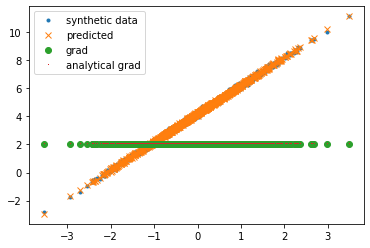

In [57]:
# Neural network that takes 2 features and outputs 1 value per sample
net = torch.nn.Sequential(torch.nn.Linear(2, 10), torch.nn.PReLU(),
                          torch.nn.BatchNorm1d(10), torch.nn.Dropout(0.25),
                          torch.nn.Linear(10, 1))
# Define optimizer
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
X, y = run_net(net, opt, synthetic_only1, epochs=10)

Quadratic data wrt to one input:

epoch 0, loss 0.760280,             grad compare 0.936703
epoch 1, loss 0.213233,             grad compare 0.529415
epoch 2, loss 0.167855,             grad compare 0.464414
epoch 3, loss 0.164806,             grad compare 0.453569
epoch 4, loss 0.143755,             grad compare 0.465533
************************************************************
Print one batch input & its Jacobian
Jacobian shape: torch.Size([5, 1, 5, 2])
2X: tensor([[-1.4508,  1.2205],
        [-0.8558,  0.8964],
        [ 4.3820, -1.8133],
        [-1.2728, -2.6301],
        [-2.6921,  2.7826]])
Jacobian summed: tensor([[-3.2363, -0.0988],
        [ 0.0700, -0.0517],
        [ 3.0958,  0.0774],
        [ 0.0361, -0.0253],
        [-3.2128, -0.1264]])
mse diff: 0.7718819379806519


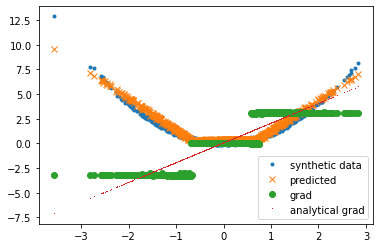

In [58]:
# Neural network that takes 2 features and outputs 1 value per sample
net = torch.nn.Sequential(torch.nn.Linear(2, 10), torch.nn.PReLU(),
                          torch.nn.BatchNorm1d(10), torch.nn.Dropout(0.25),
                          torch.nn.Linear(10, 4), torch.nn.PReLU(),
                          torch.nn.BatchNorm1d(4), torch.nn.Dropout(0.25),
                          torch.nn.Linear(4, 1))
# Define optimizer
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.6)
X, y = run_net(net, opt, synthetic_quad, epochs=5)

## A2. Experiment: just $L_{perp}$ vs. $k_{brk}$

In [59]:
# Lperp is the second to last column in the 15 derived variables
Lperp_set = torch.utils.data.TensorDataset(
    torch.nn.functional.normalize(deriv[:, 13].reshape(-1, 1), dim=0), dep)

# Check dimensions
print(Lperp_set[:][0].shape)

# Split
train_Lperp, valid_Lperp, test_Lperp = torch.utils.data.random_split(
    Lperp_set, splits)

# Define dataloaders
BATCH_SIZE = 128
NUM_WORK = 2
train_loader_Lperp = torch.utils.data.DataLoader(
    dataset=train_Lperp, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
valid_loader_Lperp = torch.utils.data.DataLoader(
    dataset=valid_Lperp, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)
test_loader_Lperp = torch.utils.data.DataLoader(
    dataset=test_Lperp, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=NUM_WORK)

torch.Size([107366, 1])


In [60]:
net8_4_Lperp = Net(1, (8, 4), 1, True, 0.25, use_prelu=True)
opt8_4_Lperp = torch.optim.SGD(net8_4_Lperp.parameters(), LEARN_RATE, 0.5)
_ = train_epochs(train_loader_Lperp, valid_loader_Lperp, 
                 model=net8_4_Lperp, loss_fun=mse, 
                 optimizer=opt8_4_Lperp, epochs=5, verbose=True)

epoch: 0	training loss: 1.669e-03	validation loss: 1.074e-11
epoch: 1	training loss: 1.138e-11	validation loss: 1.073e-11
epoch: 2	training loss: 1.140e-11	validation loss: 1.071e-11
epoch: 3	training loss: 1.137e-11	validation loss: 1.076e-11
epoch: 4	training loss: 1.138e-11	validation loss: 1.071e-11


Test set MSE: 1.094e-11


Text(0, 0.5, 'k_brk predictions')

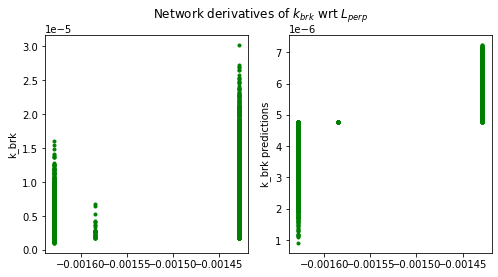

In [61]:
test_loss, j_Lperp = test_loop(test_loader_Lperp, net8_4_Lperp, mse, get_jacobian=True)
print('Test set MSE: {:.3e}'.format(test_loss))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Network derivatives of $k_{brk}$ wrt $L_{perp}$')

# y: actual labels
ax1.plot(j_Lperp[:, 0].reshape(-1, 1), j_Lperp[:, -1], 'g.')
ax1.set_ylabel('k_brk')

# yhat: predictions
ax2.plot(j_Lperp[:, 0].reshape(-1, 1), j_Lperp[:, -2], 'g.')
ax2.set_ylabel('k_brk predictions')

In [75]:
# Convert this uploaded notebook to HTML in Colab
%%shell
jupyter nbconvert --to html /content/hw2.ipynb

[NbConvertApp] Converting notebook /content/hw2.ipynb to html
[NbConvertApp] Writing 1551506 bytes to /content/hw2.html
